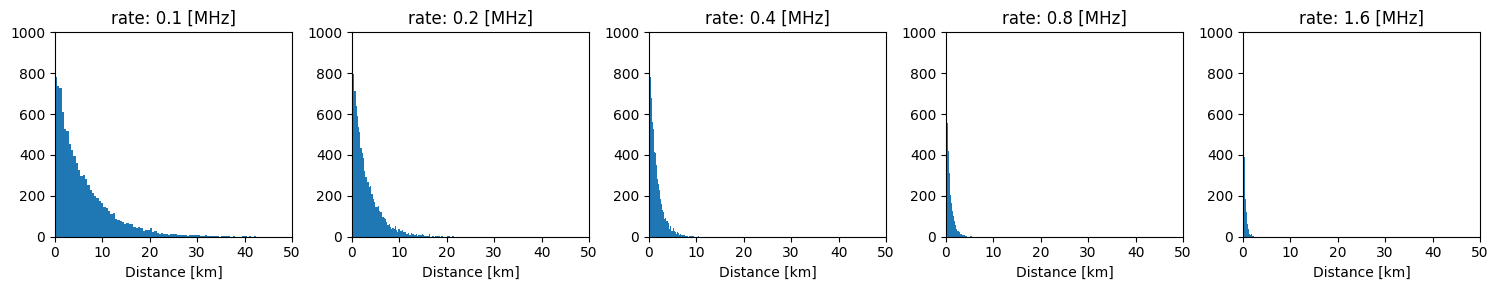

In [2]:
import numpy as np
import scipy.constants as con
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,5,  figsize=(15, 3))
for i,ax in enumerate(axs):
    rate = 0.1e6 * 2**i
    dts = np.random.default_rng().exponential(scale=1/rate, size=10000)
    ax.hist(con.speed_of_light * dts * 2 / 1000,bins=100)
    ax.set_xlabel('Distance [km]')
    ax.set_xlim([0,50])
    ax.set_ylim([0,1000])
    ax.set_title(f'rate: {rate/1e6} [MHz]')
plt.tight_layout()

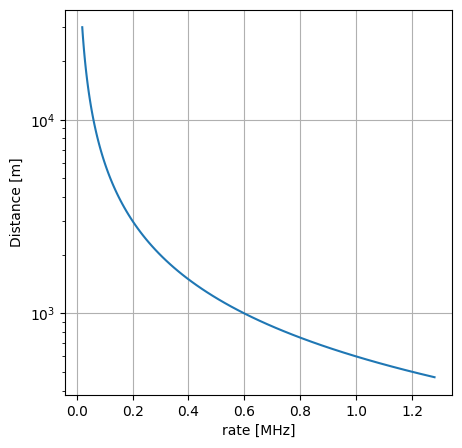

In [3]:

rates = [0.01e6 * 2**i for i in np.linspace(1,7,100)]
fig, axs = plt.subplots(1,1,  figsize=(5, 5))
axs.plot(np.array(rates) / 1e6, [con.speed_of_light * 2 / rate for rate in rates])
axs.set_ylabel('Distance [m]')
axs.set_yscale('log')
axs.set_xlabel('rate [MHz]')
axs.grid()

In [318]:
from scipy.stats import binom, norm, truncnorm

pos = 10
values = [i*10 for i in range(101)]

loc = values.index(pos)/len(values)
a, b = 0-loc,1-loc
x = np.linspace(truncnorm.ppf(0.00000001, a, b),
                truncnorm.ppf(0.99999999, a, b), len(values))

std = 0.1
probs = truncnorm.pdf(x, a/std, b/std, scale=std, loc=loc)/len(x)
err = 1-sum(probs)
probs[probs.argmax()] += err
samples = np.random.choice(values, size=100000 , p=probs)

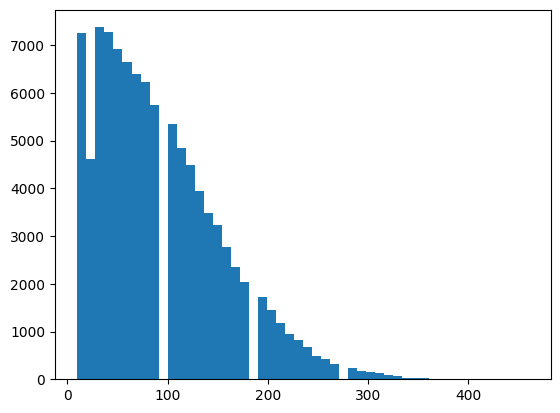

In [319]:
plt.hist(samples, bins=50)
plt.show()

In [317]:
probs.argmax()

2

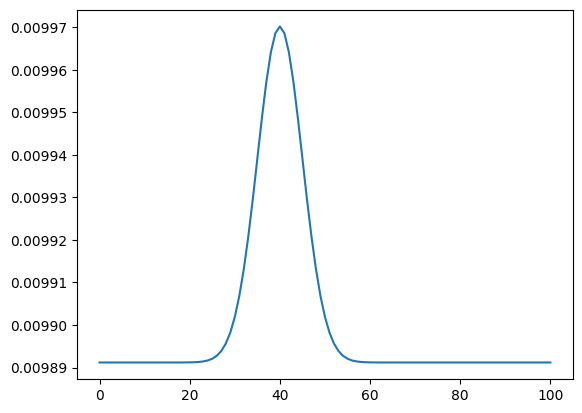

In [257]:
plt.plot(probs)

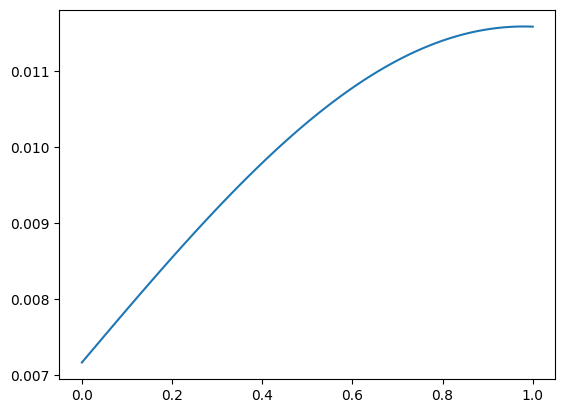

In [93]:
plt.plot(x,truncnorm.pdf(x, a, b, loc=loc)/len(x))


In [94]:
bulk = sum((truncnorm.pdf(x, a, b, loc=loc)/len(x))[:-1])
1-bulk

0.01221338600966737

In [95]:
(truncnorm.pdf(x, a, b, loc=loc)/len(x))[-1]

0.011580187998785806

In [342]:
import torch.multiprocessing as mp
import time

with mp.Pool(processes=10) as pool:
    y_temp = pool.map(np.sin, [i for i in np.linspace(2*np.pi,0,10000)])
    pool.close()
    pool.join()

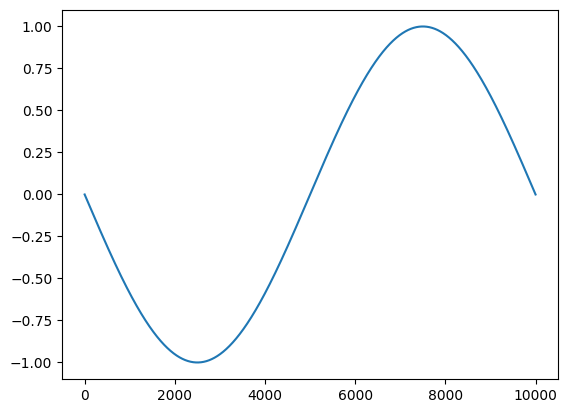

In [343]:
plt.plot(y_temp)

In [134]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses
Fr = 0.81 # min threshold fidelity

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def D_H(w1,w2, transform=False):
    e2ew = np.prod([w1, w2]) 

    F = (3*e2ew+1)/4 if transform else e2ew
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2, transform=False): 
    val = np.log(R*D_H(w1,w2, transform))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 + (4*Fr-1)/3 - np.prod([w1,w2])

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**i for i in np.linspace(1,10,100)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)) # transmissivity
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,100), (0.91,1.), (0.91,1.)), method='L-BFGS-B')
    rate, fidels, fidelu = sol.x
    U = 2*U_D(rate, fidels, fidelu, transform=True)

    res['Server link'].append(fidels)
    res['User link'].append(fidelu)
    res['Utility'].append(U)
    res['Fidelity'].append(fidels*fidelu)
    res['Rate'].append(2*rate)
    res['Distance [km]'].append(2*i)
df_res = pd.DataFrame.from_records(res)


In [135]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Text(0, 0.5, 'Fidelity')

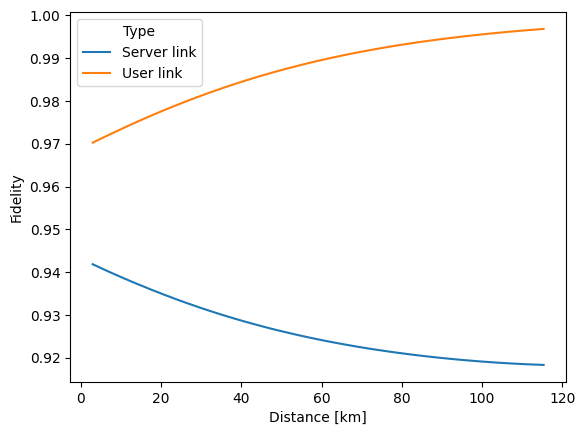

In [136]:
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')

<Axes: xlabel='Distance [km]', ylabel='Utility'>

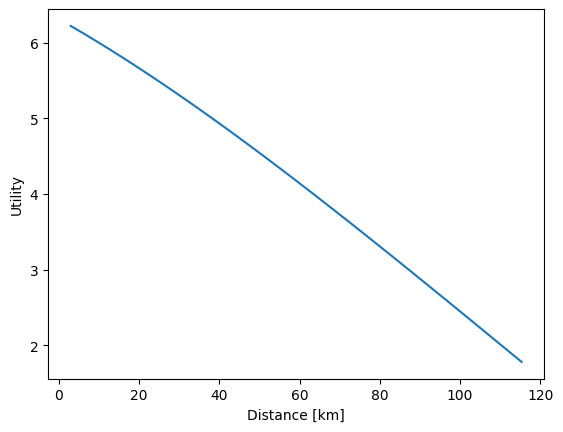

In [137]:
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True)

(0.7, 1.0)

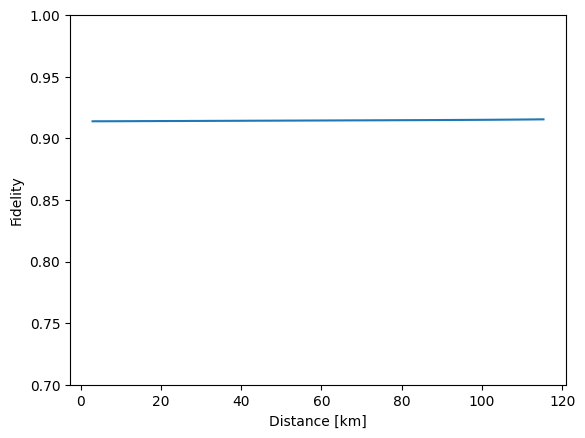

In [138]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True)
plt.ylim([0.7,1])

<Axes: xlabel='Distance [km]', ylabel='Rate'>

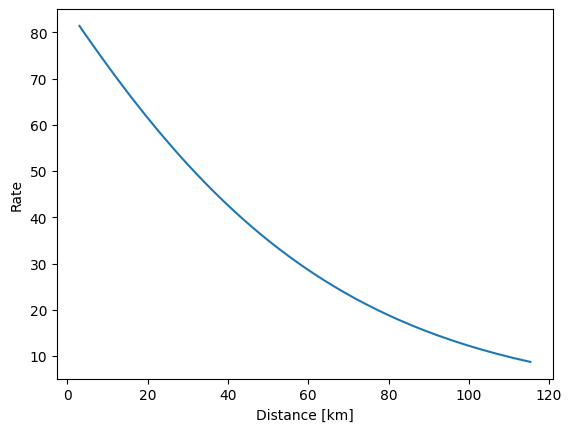

In [139]:
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True)

In [175]:
import pickle
import pandas as pd
with open('/Users/localadmin/Documents/git/surdata/qswitch/Sur_qswitch_nleafnodes3_0.10h_objective-servernode_SEED42_02-02-2024_15:43:14.pkl', 'rb') as file:
    df = pickle.load(file)

Text(0.5, 0, 'Distance [km]')

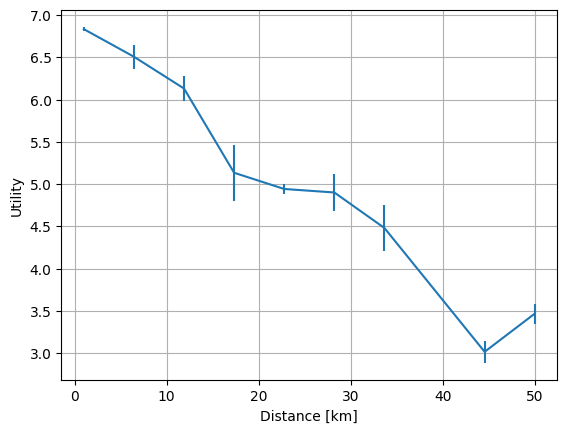

In [176]:
plt.errorbar(df['server_distance'], df['Utility'],df['Utility_std'])
plt.grid()
plt.ylabel('Utility')
plt.xlabel('Distance [km]')

Text(0, 0.5, 'Fidelity')

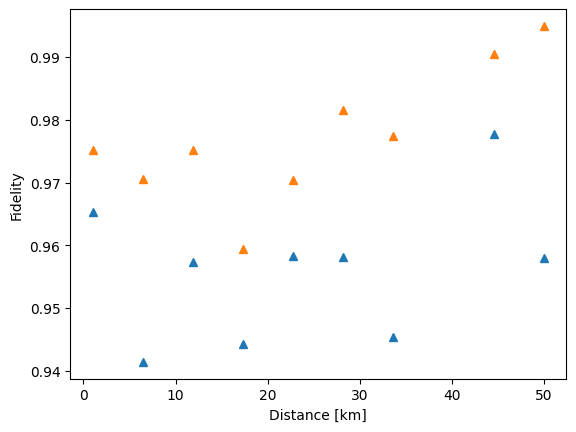

In [177]:
plt.plot(df['server_distance'], 1-df['bright_state_server'], '^')
plt.plot(df['server_distance'], 1-df['bright_state_user'], '^')
plt.xlabel('Distance [km]')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Rate [Hz]')

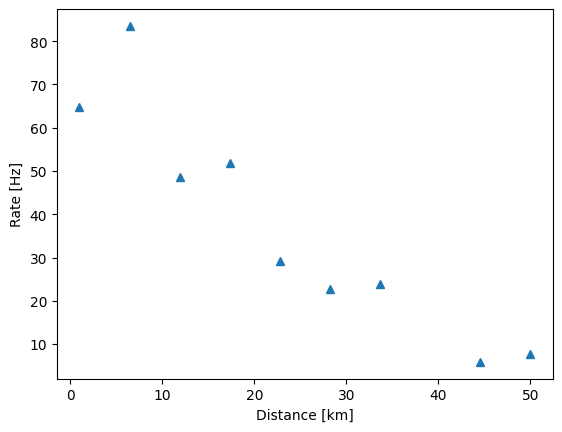

In [178]:
plt.plot(df['server_distance'], df['Rate'], '^' )
plt.xlabel('Distance [km]')
plt.ylabel('Rate [Hz]')